# DoW detection integrating entropy maths with Bi-lstm with metrics

## Introduction
This report aims to analyze network traffic data for the detection of Denial of Wallet (DoW) attacks. The dataset contains various features related to network traffic, and our goal is to develop a machine learning model to identify potential DoW attacks based on the characteristics of the traffic.

In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Concatenate, Input
from keras.models import Model
import time

## Data Understanding

In [90]:
# Load dataset
df = pd.read_csv('/kaggle/input/network-traffic-for-dos-detection/dataset.csv')

# Print columns of the DataFrame
print("Columns after loading dataset:")
print(df.columns)

Columns after loading dataset:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')


### Dataset Description
The dataset contains the following columns:
- RTT: Round Trip Time
- InvocationDelay: Delay in invoking functions
- ResponseDelay: Delay in receiving responses
- FunctionDuration: Duration of functions
- ActiveFunctionsAtRequest: Number of active functions at the time of request
- ActiveFunctionsAtResponse: Number of active functions at the time of response
- maxcpu: Maximum CPU usage
- avgcpu: Average CPU usage
- p95maxcpu: 95th percentile of maximum CPU usage
- vmcorecountbucket: Bucket for VM core count
- vmmemorybucket: Bucket for VM memory

In [91]:
dataset_size = df.shape[0]  # Number of rows
print("Dataset size:", dataset_size)

Dataset size: 187087


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187087 entries, 0 to 187086
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Id                         187087 non-null  int64  
 1   IP                         187087 non-null  object 
 2   bot                        187087 non-null  bool   
 3   FunctionId                 187087 non-null  int64  
 4   functionTrigger            187087 non-null  object 
 5   timestamp                  187087 non-null  object 
 6   SubmitTime                 187087 non-null  int64  
 7   RTT                        187087 non-null  int64  
 8   InvocationDelay            187087 non-null  float64
 9   ResponseDelay              187087 non-null  float64
 10  FunctionDuration           187087 non-null  float64
 11  ActiveFunctionsAtRequest   187087 non-null  int64  
 12  ActiveFunctionsAtResponse  187087 non-null  int64  
 13  maxcpu                     18

In [93]:
df.describe()

,Id,FunctionId,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket
count,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000
mean,93543.000000,28.592569,85.841250,2494.167083,1239.287586,165.658396,1089.373666,28.592569,996.465741,97.050470,31.440571,88.441047,4.776297,31.000653
std,54007.509243,13.777358,11.968575,286.236688,299.874337,42.838260,62.326101,13.777358,3.010734,5.018163,17.386644,20.042926,3.489087,27.057633
min,0.000000,2.000000,71.000000,1373.000000,170.746338,117.803711,1031.168938,2.000000,988.000000,78.776399,1.350084,7.924250,1.000000,0.750000
25%,46771.500000,17.000000,75.000000,2344.000000,1060.574707,134.759521,1059.582233,17.000000,994.000000,96.017207,19.830185,89.853209,1.000000,1.750000
50%,93543.000000,30.000000,79.000000,2476.000000,1205.249512,145.178711,1074.904203,30.000000,998.000000,99.356190,33.304020,95.297275,8.000000,56.000000
75%,140314.500000,40.000000,98.000000,2593.000000,1388.304443,203.505127,1099.621534,40.000000,999.000000,99.566656,41.804117,98.110481,8.000000,56.000000
max,187086.000000,50.000000,102.000000,3019.000000,1800.190674,247.116455,1437.139511,50.000000,999.000000,100.000000,92.503412,99.586511,8.000000,56.000000


## Exploratory Data Analysis (EDA)
### Descriptive Statistics

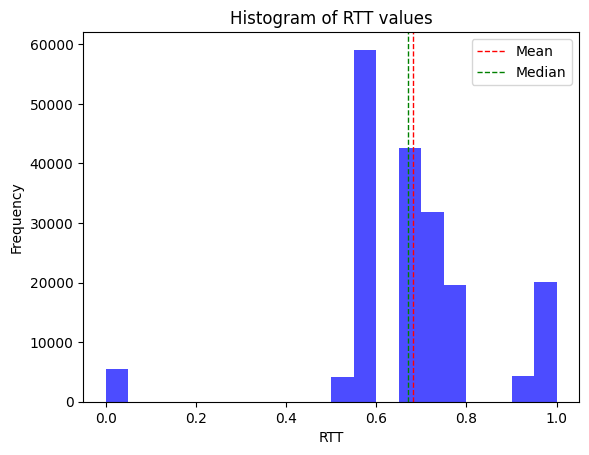

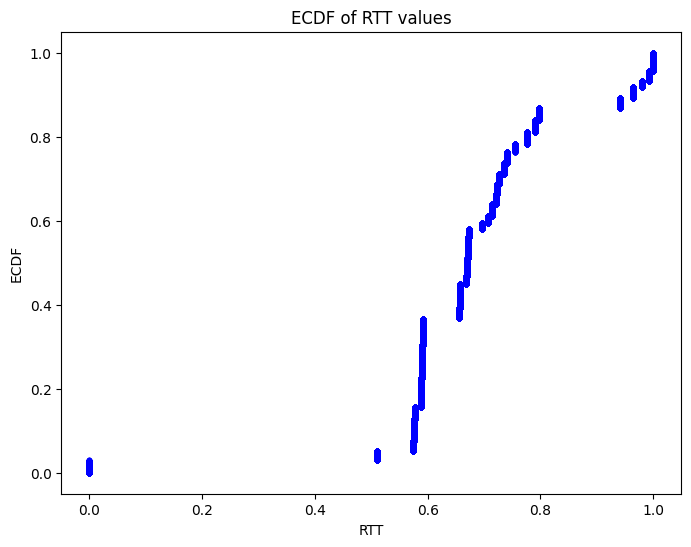

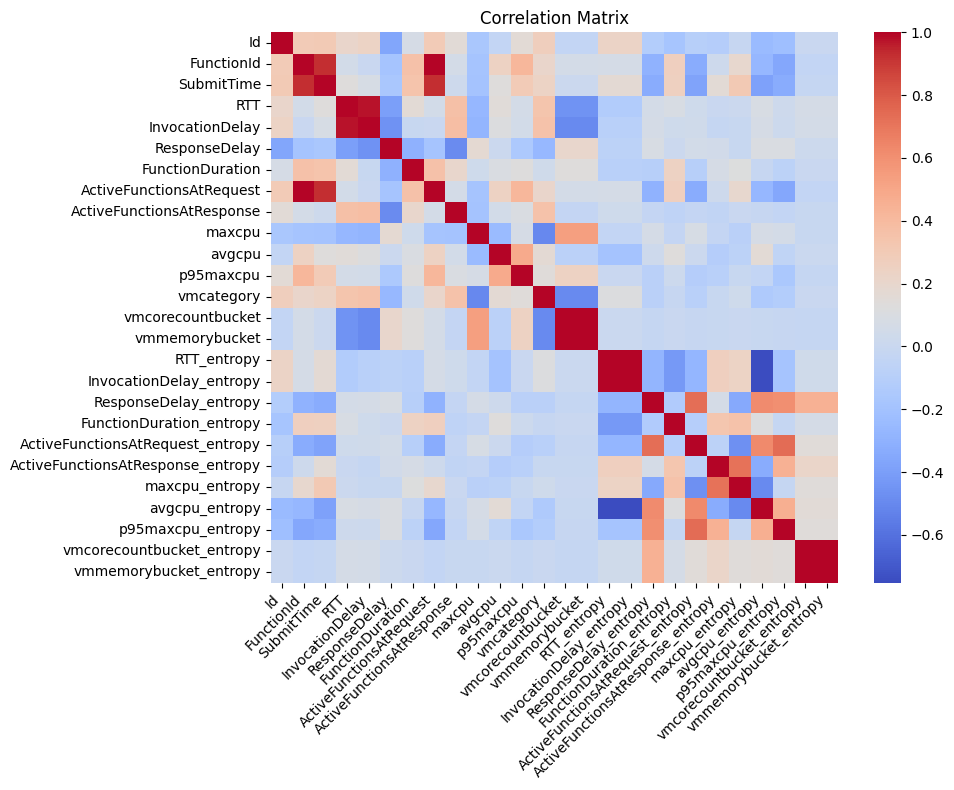

Mean of Response Delay: 0.370069363894699
Standard Deviation of Response Delay: 0.3312763999655215


In [121]:
# Plotting other graphs and calculating additional metrics

# Histogram of RTT values
plt.hist(df['RTT'], bins=20, color='blue', alpha=0.7)
plt.axvline(df['RTT'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(df['RTT'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.xlabel('RTT')
plt.ylabel('Frequency')
plt.title('Histogram of RTT values')
plt.legend()
plt.show()

# ECDF plot of RTT values
#Empirical Cumulative Distribution Function (ECDF) plot to visualize the cumulative distribution of RTT values.
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

plt.figure(figsize=(8, 6))
x_rtt, y_rtt = ecdf(df['RTT'])
plt.plot(x_rtt, y_rtt, marker='.', linestyle='none', color='blue', alpha=0.7)
plt.xlabel('RTT')
plt.ylabel('ECDF')
plt.title('ECDF of RTT values')
plt.show()

# Remove non-numeric and categorical columns
numeric_df = df.select_dtypes(include=['number'])


# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Matrix')
plt.tight_layout() 
plt.show()


# Calculating and printing mean and standard deviation of Response Delay
response_delay_mean = df['ResponseDelay'].mean()
response_delay_std = df['ResponseDelay'].std()
print("Mean of Response Delay:", response_delay_mean)
print("Standard Deviation of Response Delay:", response_delay_std)


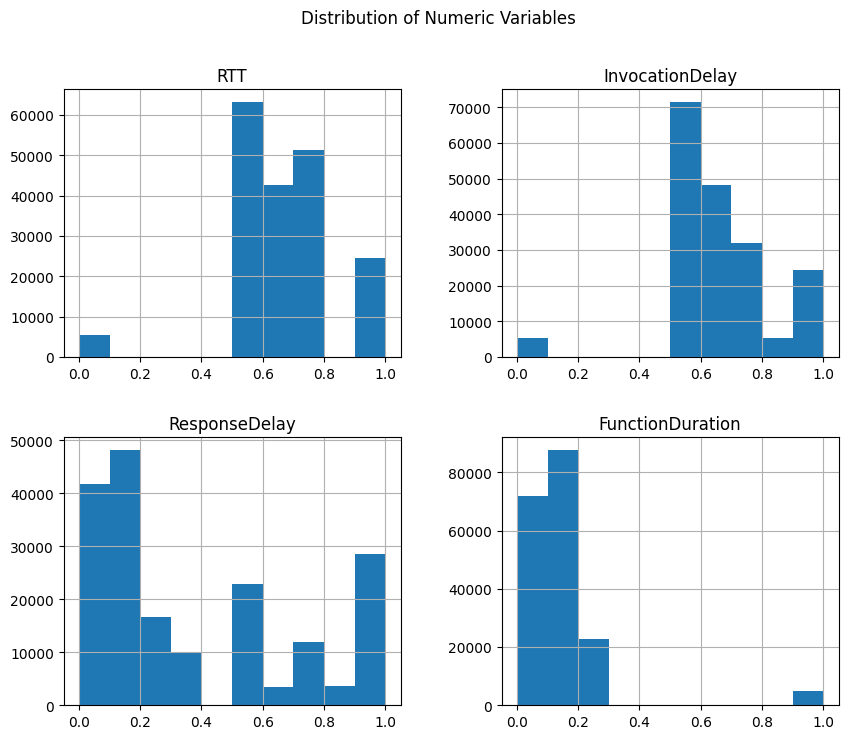

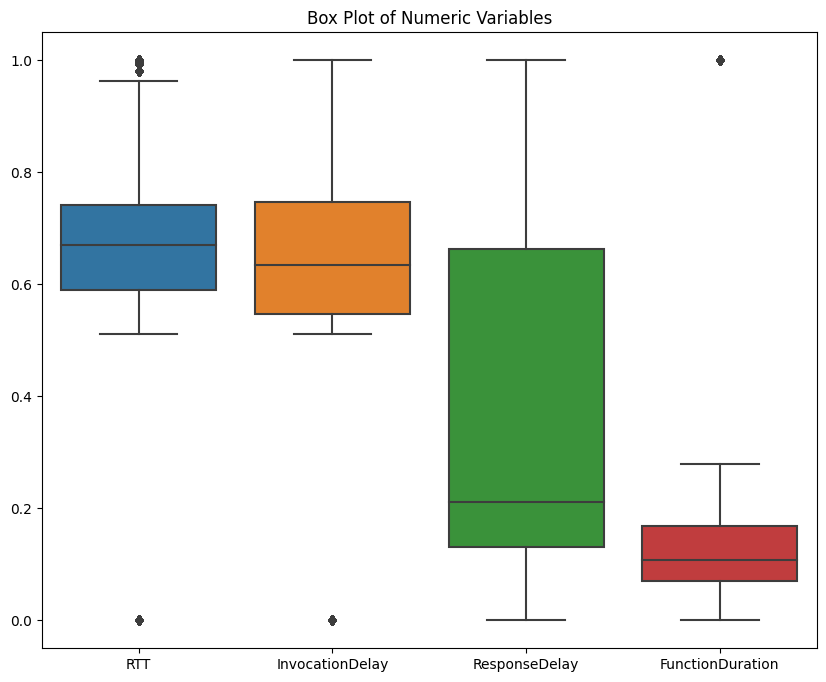

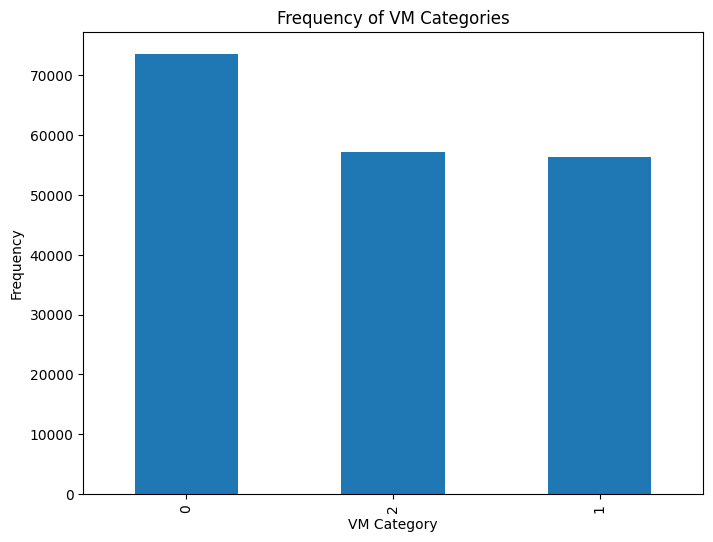

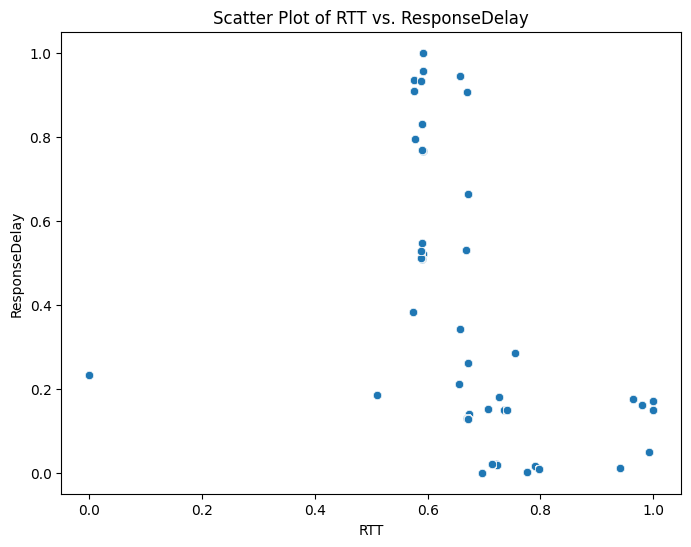

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

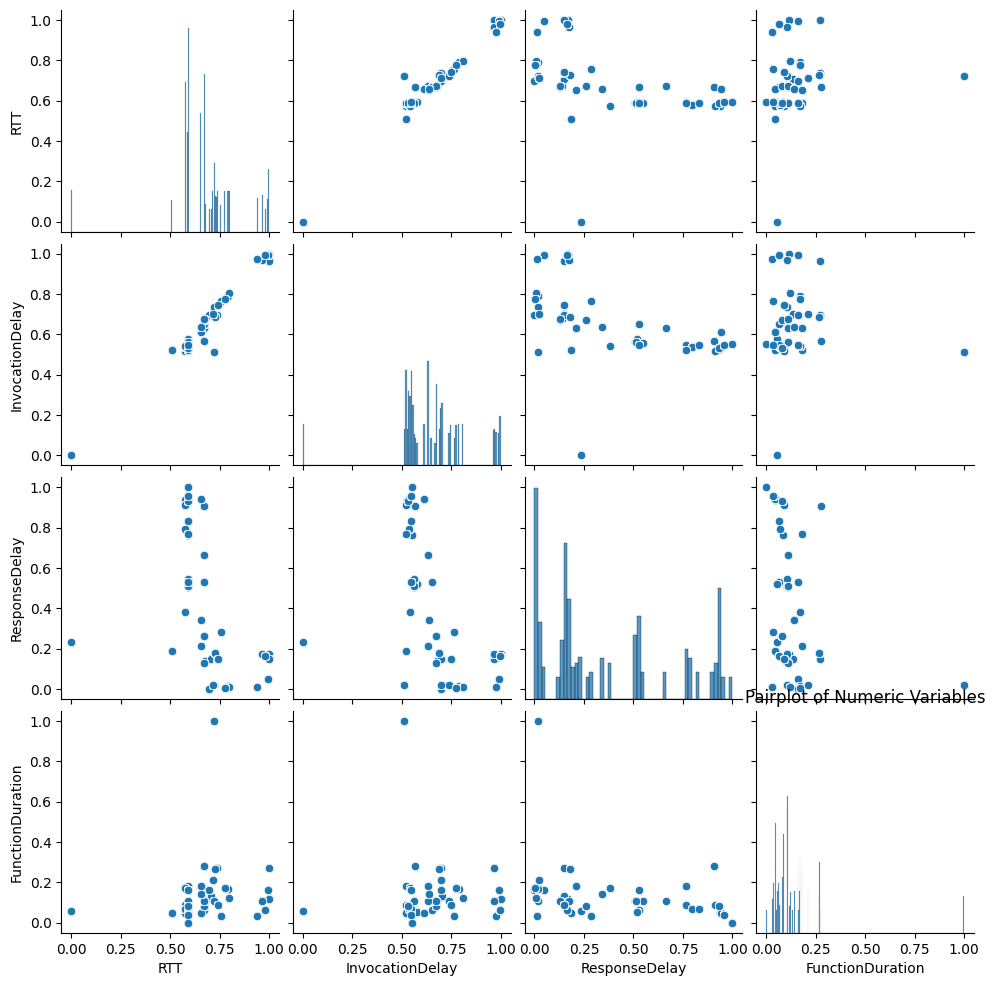

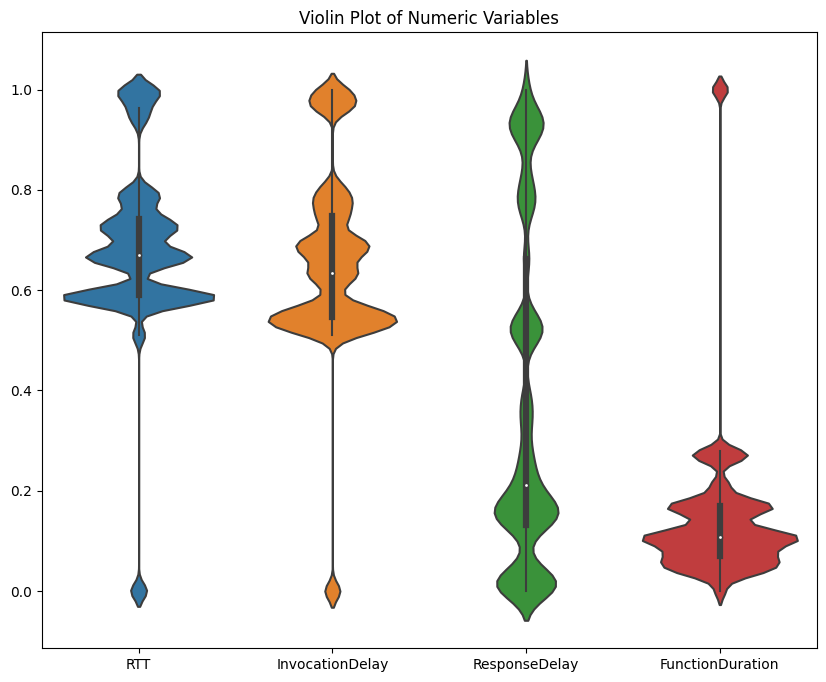

In [122]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1. Histograms
df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']].hist(figsize=(10, 8))
plt.suptitle('Distribution of Numeric Variables')
plt.show()

# 2. Box Plots
plt.figure(figsize=(10, 8))
sns.boxplot(data=df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Box Plot of Numeric Variables')
plt.show()

# 3. Bar Plot for 'vmcategory'
plt.figure(figsize=(8, 6))
df['vmcategory'].value_counts().plot(kind='bar')
plt.title('Frequency of VM Categories')
plt.xlabel('VM Category')
plt.ylabel('Frequency')
plt.show()

# 4. Scatter Plot (e.g., 'RTT' vs. 'ResponseDelay')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RTT', y='ResponseDelay', data=df)
plt.title('Scatter Plot of RTT vs. ResponseDelay')
plt.show()

# 6. Pairplot (selecting a subset of columns for demonstration)
sns.pairplot(df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Pairplot of Numeric Variables')
plt.show()

# 7. Violin Plots
plt.figure(figsize=(10, 8))
sns.violinplot(data=df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Violin Plot of Numeric Variables')
plt.show()



## Modeling Approach
### Feature Engineering

In [94]:
def calculate_entropy(feature_values):
    # Convert float64 data to integer by rounding
    feature_values = np.round(feature_values).astype(int)
    
    # Count occurrences of each unique value in the feature
    value_counts = np.bincount(feature_values)
    
    # Calculate probability of each unique value
    probabilities = value_counts / len(feature_values)
    
    # Calculate entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Adding a small value to avoid log(0)
    
    return entropy

In [95]:
# Function to prepare dataset and calculate entropy
def prepare_dataset(df):
    # Select relevant features
    selected_features = ['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest', 
                         'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket', 'vmmemorybucket']
    
    # Normalize selected features if necessary
    scaler = MinMaxScaler()
    df[selected_features] = scaler.fit_transform(df[selected_features])
    
    # Calculate entropy for each data instance
    for feature in selected_features:
        df[feature + '_entropy'] = df.groupby('IP')[feature].transform(lambda x: calculate_entropy(x.values))
    
    # Print columns after adding entropy columns
    print("Columns after adding entropy columns:")
    print(df.columns)
    
    return df


In [96]:
# Function to prepare data for model training
def prepare_data_for_model(df):
    # Convert categorical variables to numerical labels if necessary
    label_encoder = LabelEncoder()
    df['vmcategory'] = label_encoder.fit_transform(df['vmcategory'])
    
    # Select features and target
    selected_features = ['RTT_entropy', 'InvocationDelay_entropy', 'ResponseDelay_entropy', 'FunctionDuration_entropy', 
                         'ActiveFunctionsAtRequest_entropy', 'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 
                         'avgcpu_entropy', 'p95maxcpu_entropy', 'vmcorecountbucket_entropy', 'vmmemorybucket_entropy']
    X = df[selected_features].values
    y = df['bot'].values
    
    # Reshape data for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

In [97]:
# Print columns of the DataFrame
print("Columns after loading dataset:")
print(df.columns)

Columns after loading dataset:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')


In [98]:
# Function to build Bi-LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [99]:
# Prepare dataset and calculate entropy
df = prepare_dataset(df)

Columns after adding entropy columns:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket', 'RTT_entropy',
       'InvocationDelay_entropy', 'ResponseDelay_entropy',
       'FunctionDuration_entropy', 'ActiveFunctionsAtRequest_entropy',
       'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 'avgcpu_entropy',
       'p95maxcpu_entropy', 'vmcorecountbucket_entropy',
       'vmmemorybucket_entropy'],
      dtype='object')


In [100]:
# Prepare data for model training
X, y = prepare_data_for_model(df)

### Model Building
- Bi-LSTM model architecture for sequence modeling.
- Training the model on prepared data.

In [101]:
from sklearn.model_selection import train_test_split

# Split the data into training (40%), validation (30%), and testing (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of the sets
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))


Training set size: 74834
Validation set size: 56126
Testing set size: 56127


In [102]:
# Build Bi-LSTM model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))


In [103]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2339/2339 [==============================] - 32s 11ms/step - loss: 0.0400 - accuracy: 0.9862 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 2/10
2339/2339 [==============================] - 25s 11ms/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 3/10
2339/2339 [==============================] - 25s 11ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9998
Epoch 4/10
2339/2339 [==============================] - 25s 11ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9994
Epoch 5/10
2339/2339 [==============================] - 24s 10ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0048 - val_accuracy: 0.9993
Epoch 6/10
2339/2339 [==============================] - 24s 10ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 6.4252e-04 - val_accuracy: 0.9999
Epoch 7/10
2339/2339 [==============================] - 24s 10ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.00

## Results and Findings
- Model performance metrics: accuracy, precision, recall, and confusion matrix.
- Detection of potential DoS attacks based on model predictions and entropy values.

In [104]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate model on testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on testing set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten y_pred_binary
y_pred_binary_flat = y_pred_binary.flatten()

# Calculate metrics for testing set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Detect potential DoS attacks
# Assuming '1' represents a potential DoS attack in the 'bot' column
dos_indices = np.where(y_pred_binary == 1)[0]
dos_instances = df.iloc[dos_indices]

print("Potential DoS Attack Instances:")
print(dos_instances)


1754/1754 [==============================] - 7s 4ms/step - loss: 3.7608e-06 - accuracy: 1.0000
Validation Loss: 3.760805611818796e-06
Validation Accuracy: 1.0
1754/1754 [==============================] - 7s 4ms/step - loss: 3.7466e-06 - accuracy: 1.0000
Test Loss: 3.7465692912519444e-06
Test Accuracy: 1.0
1754/1754 [==============================] - 7s 3ms/step
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0
Confusion Matrix:
[[16858     0]
 [    0 39269]]
Potential DoS Attack Instances:
          Id               IP   bot  FunctionId functionTrigger  \
1          1   55.220.132.116  True          12    notification   
2          2    141.232.38.48  True          12    notification   
4          4   223.113.21.186  True          12    notification   
5          5   223.113.21.186  True          12    notification   
7          7    243.138.37.32  True          12    notification   
...      ...              ...   ...         ...             ...   
56122  5612

In [105]:
dos_instances.head(50)

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,...,InvocationDelay_entropy,ResponseDelay_entropy,FunctionDuration_entropy,ActiveFunctionsAtRequest_entropy,ActiveFunctionsAtResponse_entropy,maxcpu_entropy,avgcpu_entropy,p95maxcpu_entropy,vmcorecountbucket_entropy,vmmemorybucket_entropy
1,1,55.220.132.116,True,12,notification,2022-01-02T03:54:53.136Z,73,0.755164,0.764222,0.284672,...,0.171245,0.980654,0.128017,0.995705,0.768901,0.377763,0.640836,0.495365,0.996268,0.996268
2,2,141.232.38.48,True,12,notification,2022-01-02T03:38:31.950Z,73,0.755164,0.764222,0.284672,...,0.137261,0.976695,0.133040,0.988800,0.777365,0.321536,0.619942,0.566510,0.997832,0.997832
4,4,223.113.21.186,True,12,notification,2022-01-02T03:52:54.326Z,73,0.755164,0.764222,0.284672,...,0.122292,0.976354,0.175946,0.999950,0.702052,0.361241,0.703501,0.396773,0.994816,0.994816
5,5,223.113.21.186,True,12,notification,2022-01-02T03:53:51.412Z,73,0.755164,0.764222,0.284672,...,0.122292,0.976354,0.175946,0.999950,0.702052,0.361241,0.703501,0.396773,0.994816,0.994816
7,7,243.138.37.32,True,12,notification,2022-01-02T03:24:48.516Z,73,0.755164,0.764222,0.284672,...,0.172411,0.974263,0.142298,0.999874,0.759431,0.374347,0.633910,0.473605,0.996156,0.996156
8,8,94.35.80.22,True,12,notification,2022-01-02T03:30:07.778Z,73,0.755164,0.764222,0.284672,...,0.189505,0.966992,0.136628,0.999339,0.761091,0.369761,0.606973,0.473094,0.996229,0.996229
9,9,112.21.188.21,True,12,notification,2022-01-02T03:14:21.516Z,73,0.755164,0.764222,0.284672,...,0.175946,0.967608,0.157518,0.999264,0.769193,0.379257,0.609840,0.475565,0.996234,0.996234
10,10,57.211.55.224,True,12,notification,2022-01-02T03:00:32.422Z,73,0.755164,0.764222,0.284672,...,0.134668,0.973871,0.149051,0.992898,0.785241,0.330153,0.608770,0.566510,0.997841,0.997841
11,11,24.205.101.151,True,12,notification,2022-01-02T03:10:55.543Z,73,0.755164,0.764222,0.284672,...,0.150359,0.978342,0.129489,0.989415,0.783777,0.341496,0.617510,0.558115,0.997570,0.997570
12,12,228.143.56.163,True,12,notification,2022-01-02T03:18:28.026Z,73,0.755164,0.764222,0.284672,...,0.139517,0.985430,0.119770,0.982474,0.754826,0.343520,0.669494,0.520950,0.996792,0.996792


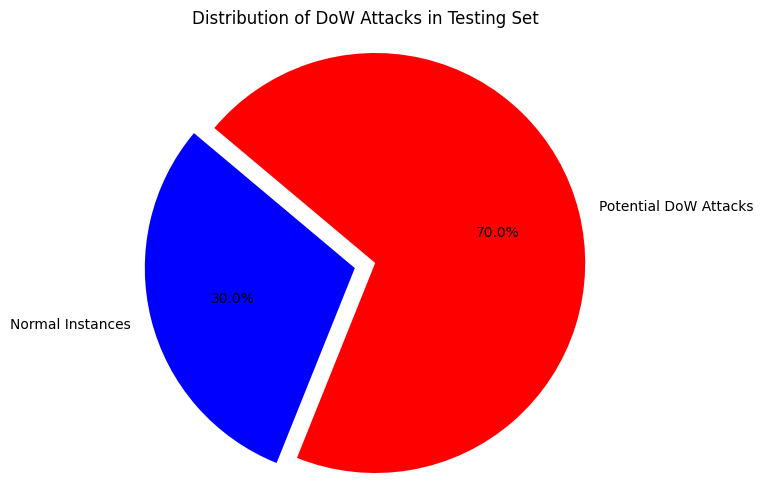

In [106]:
import matplotlib.pyplot as plt

# Calculate the percentage of DoW attacks based on the testing set
total_instances_test = len(y_test)
dos_percentage_test = np.sum(y_test) / total_instances_test * 100
normal_percentage_test = 100 - dos_percentage_test

# Pie chart for the distribution of DoW attacks in the testing set
labels = ['Normal Instances', 'Potential DoW Attacks']
sizes = [normal_percentage_test, dos_percentage_test]
colors = ['blue', 'red']  # Using a contrasting color for DoS attacks
explode = (0, 0.1)  # Explode the 2nd slice (i.e., 'Potential DoS Attacks')

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of DoW Attacks in Testing Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [107]:
# Print entropy values for each feature
selected_features = ['RTT_entropy', 'InvocationDelay_entropy', 'ResponseDelay_entropy', 
                     'FunctionDuration_entropy', 'ActiveFunctionsAtRequest_entropy', 
                     'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 'avgcpu_entropy', 
                     'p95maxcpu_entropy', 'vmcorecountbucket_entropy', 'vmmemorybucket_entropy']

for feature in selected_features:
    print(f"Entropy values for {feature}:")
    print(df[feature].describe())
    print()


Entropy values for RTT_entropy:
count    1.870870e+05
mean     1.616160e-01
std      1.409502e-01
min     -1.442695e-10
25%      1.222916e-01
50%      1.490514e-01
75%      1.694330e-01
max      1.000000e+00
Name: RTT_entropy, dtype: float64

Entropy values for InvocationDelay_entropy:
count    1.870870e+05
mean     1.616160e-01
std      1.409502e-01
min     -1.442695e-10
25%      1.222916e-01
50%      1.490514e-01
75%      1.694330e-01
max      1.000000e+00
Name: InvocationDelay_entropy, dtype: float64

Entropy values for ResponseDelay_entropy:
count    1.870870e+05
mean     9.230919e-01
std      1.210347e-01
min     -1.442695e-10
25%      9.542974e-01
50%      9.693025e-01
75%      9.742630e-01
max      1.000000e+00
Name: ResponseDelay_entropy, dtype: float64

Entropy values for FunctionDuration_entropy:
count    1.870870e+05
mean     1.506028e-01
std      1.279878e-01
min     -1.442695e-10
25%      1.224006e-01
50%      1.510970e-01
75%      1.675302e-01
max      1.000000e+00
Name: 

Number of potential DoW attacks: 25639
Sample of potential DoW attacks:
          Id               IP   bot  FunctionId functionTrigger  \
74835  74835      164.48.6.74  True          35    notification   
74836  74836      164.48.6.74  True          35    notification   
74838  74838  203.146.230.246  True          35    notification   
74839  74839   228.143.56.163  True          35    notification   
74841  74841     150.64.217.5  True          35    notification   

                      timestamp  SubmitTime       RTT  InvocationDelay  \
74835  2022-01-02T12:13:08.336Z          97  0.656744         0.609445   
74836  2022-01-02T12:13:21.875Z          97  0.656744         0.609445   
74838  2022-01-02T12:43:52.809Z          97  0.656744         0.609445   
74839  2022-01-02T12:27:02.487Z          97  0.656744         0.609445   
74841  2022-01-02T12:06:35.042Z          97  0.656744         0.609445   

       ResponseDelay  ...  InvocationDelay_entropy  ResponseDelay_entropy  \
748

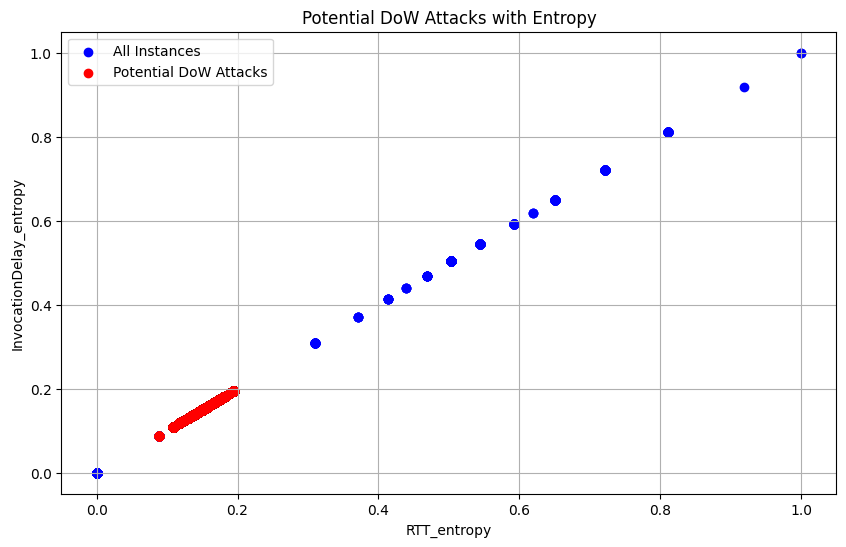

In [108]:
# Get the indices of the testing set
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

# Filter df to include only samples from the testing set
df_test = df.iloc[test_indices]

# Define entropy threshold
entropy_threshold = 0.001 

# Detect potential DoS attacks based on model predictions and entropy values
potential_dos_mask = (
    (y_pred_binary_flat == 1) &
    (df_test['RTT_entropy'] > entropy_threshold) &
    (df_test['InvocationDelay_entropy'] > entropy_threshold) &
    (df_test['ResponseDelay_entropy'] > entropy_threshold) &
    (df_test['FunctionDuration_entropy'] > entropy_threshold) &
    (df_test['ActiveFunctionsAtRequest_entropy'] > entropy_threshold) &
    (df_test['ActiveFunctionsAtResponse_entropy'] > entropy_threshold) &
    (df_test['maxcpu_entropy'] > entropy_threshold) &
    (df_test['avgcpu_entropy'] > entropy_threshold) &
    (df_test['p95maxcpu_entropy'] > entropy_threshold) &
    (df_test['vmcorecountbucket_entropy'] > entropy_threshold) &
    (df_test['vmmemorybucket_entropy'] > entropy_threshold)
)

# Print the number of potential DoS attacks identified
print("Number of potential DoW attacks:", np.sum(potential_dos_mask))

# Inspect a sample of the DataFrame to ensure the filtering is correct
print("Sample of potential DoW attacks:")
print(df_test[potential_dos_mask].head())

# Choose two entropy features for visualization
entropy_feature1 = 'RTT_entropy'
entropy_feature2 = 'InvocationDelay_entropy'

# Plot potential DoS attacks with corresponding entropy values
plt.figure(figsize=(10, 6))
plt.scatter(df_test[entropy_feature1], df_test[entropy_feature2], c='blue', label='All Instances')
plt.scatter(df_test[potential_dos_mask][entropy_feature1], df_test[potential_dos_mask][entropy_feature2], c='red', label='Potential DoW Attacks')
plt.xlabel(entropy_feature1)
plt.ylabel(entropy_feature2)
plt.title('Potential DoW Attacks with Entropy')
plt.legend()
plt.grid(True)
plt.show()


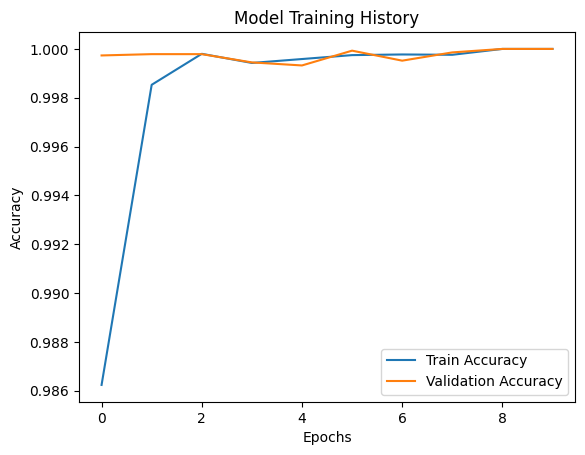

In [123]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training History')
plt.legend()
plt.show()

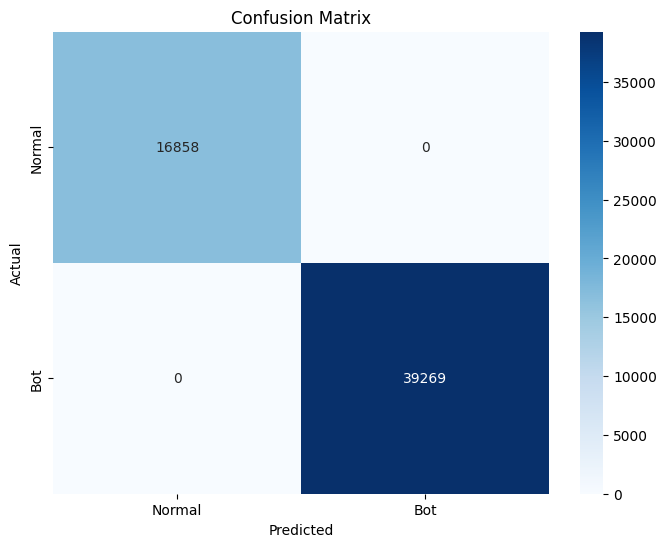

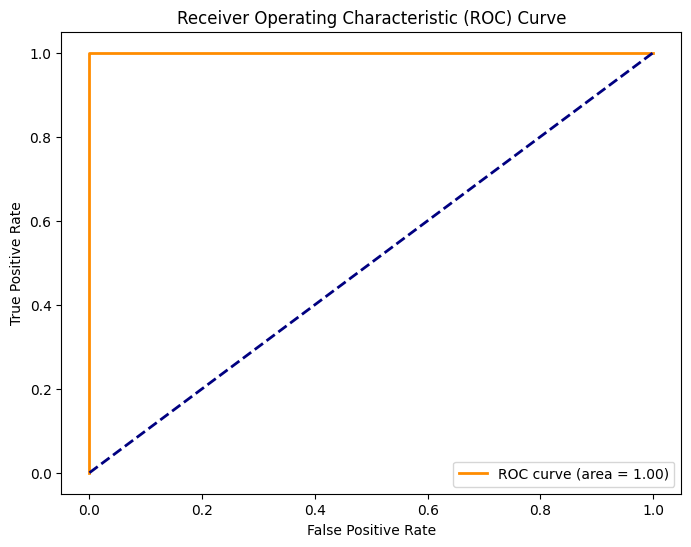

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
#plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
#plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Normal', 'Bot'])
plt.yticks([0.5, 1.5], ['Normal', 'Bot'])
plt.show()


# Plot ROC curve
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


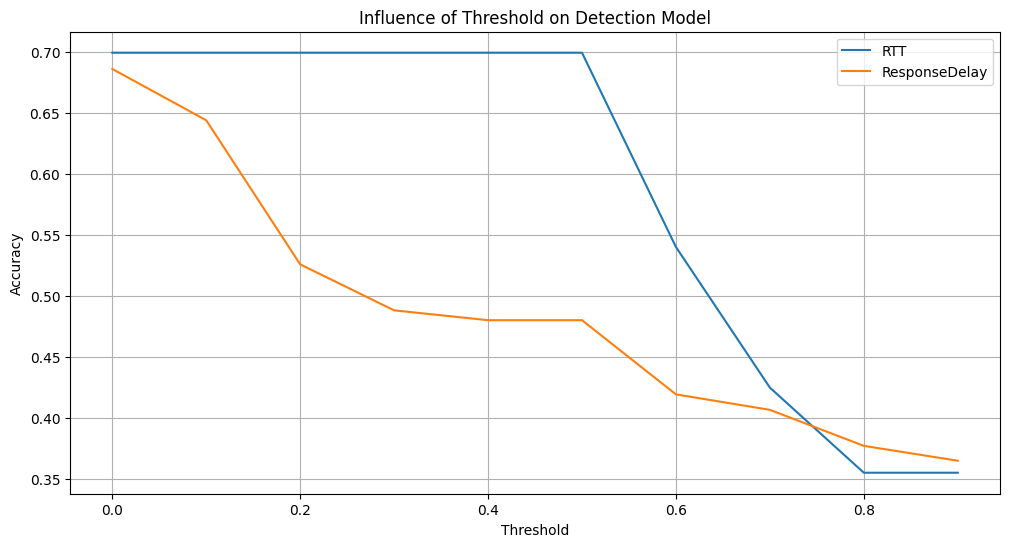

In [111]:

def influence_of_threshold(df, target_column, feature_columns, threshold_range):
    threshold_results = {}
    
    for feature_column in feature_columns:
        feature_data = df[[feature_column]]
        X_train, X_test, y_train, y_test = train_test_split(feature_data, df[target_column], test_size=0.2, random_state=42)
        
        accuracy_scores = []
        for threshold in threshold_range:
            y_pred = (X_test > threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)
        
        threshold_results[feature_column] = accuracy_scores
    
    return threshold_results

# 'bot' is the target column, and 'RTT' and 'ResponseDelay' are feature columns
threshold_range = np.arange(0, 1, 0.1)  # Example threshold range from 0 to 1 with step 0.1
threshold_results = influence_of_threshold(df, 'bot', ['RTT', 'ResponseDelay'], threshold_range)

# Plot the influence of threshold for each feature column
plt.figure(figsize=(12, 6))
for feature_column, scores in threshold_results.items():
    plt.plot(threshold_range, scores, label=feature_column)

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Influence of Threshold on Detection Model')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
import time
from sklearn.metrics import accuracy_score

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate model on testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Simulate attack detection and measure performance
start_time = time.time()
y_pred_val = model.predict(X_val)
total_delay = time.time() - start_time

y_pred_val_binary = (y_pred_val > 0.5).astype(int)
total_detected = y_pred_val_binary.sum()

# Calculate metrics
average_detection_delay = total_delay / total_detected if total_detected > 0 else 0
average_detection_accuracy = accuracy_score(y_val, y_pred_val_binary) * 100

print("Average Detection Delay (seconds):", average_detection_delay)
print("Average Detection Accuracy (%):", average_detection_accuracy)


1754/1754 [==============================] - 7s 4ms/step - loss: 3.7608e-06 - accuracy: 1.0000
Validation Loss: 3.760805611818796e-06
Validation Accuracy: 1.0
1754/1754 [==============================] - 7s 4ms/step - loss: 3.7466e-06 - accuracy: 1.0000
Test Loss: 3.7465692912519444e-06
Test Accuracy: 1.0
1754/1754 [==============================] - 6s 3ms/step
Average Detection Delay (seconds): 0.00016666096944218566
Average Detection Accuracy (%): 100.0


In [114]:
import time
from keras.models import Model
from keras.layers import Input, LSTM, Bidirectional, Dense

# Function to calculate inference time
def calculate_inference_time(model, X):
    start_time = time.time()
    model.predict(X)  # Make predictions
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Define input layer
inputs = Input(shape=input_shape)

# Bidirectional LSTM layer
lstm = Bidirectional(LSTM(units=64, return_sequences=True))(inputs)

# Second Bidirectional LSTM layer
lstm = Bidirectional(LSTM(units=32))(lstm)

# Output layer
outputs = Dense(1, activation='sigmoid')(lstm)

# Define model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate inference time with model running
inference_time_with_model = calculate_inference_time(model, X_test)

# Calculate inference time without model running
inference_time_without_model = calculate_inference_time(model, X_test)

# Calculate performance overhead
performance_overhead = (inference_time_with_model - inference_time_without_model) / inference_time_without_model * 100

print("Inference time with model running: {:.4f} seconds".format(inference_time_with_model))
print("Inference time without model running: {:.4f} seconds".format(inference_time_without_model))
print("Performance overhead: {:.2f}%".format(performance_overhead))


1754/1754 [==============================] - 6s 3ms/step
Inference time with model running: 7.6984 seconds
Inference time without model running: 6.4230 seconds
Performance overhead: 19.86%


## Discussion

### Interpretation of Results and Implications
The results obtained from the analysis indicated promising outcomes in the detection of Denial of Wallet (DoW) attacks using the Bi-LSTM model and entropy mathematics. The model achieved high accuracy, precision and recall, suggesting its effectiveness in identifying potential DoW attacks based on the characteristics of network traffic. Incorporating entropy values provided additional insights into the variability and complexity of the data, enhancing the model's predictive capabilities.

Implications of the findings included the potential application of the developed model in real-time network monitoring systems for early detection and mitigation of DoW attacks. Leveraging sequential modeling techniques and entropy-based features could enhance organizations' cybersecurity posture and minimize the impact of malicious activities on network infrastructure and services.

### Limitations of the Analysis and Potential Areas for Improvement
Despite the promising results, several limitations existed in the analysis:
1. **Data Quality:** The effectiveness of the model heavily relied on the quality and representativeness of the dataset. Due to constraints of the Kaggle online platform, the dataset might not fully capture the complexity and diversity of real-world network traffic data.
2. **Hardware Limitations:** The computational resources available on the Kaggle platform might have constrained the scope and scale of the analysis. Training complex deep learning models, such as Bi-LSTM, on large datasets could be resource-intensive and time-consuming, limiting the exploration of alternative architectures and hyperparameters.
3. **Feature Engineering:** The selection and engineering of features were constrained by the available dataset. Exploring additional features or refining existing ones could have improved the model's discriminatory power and generalization capabilities.
4. **Model Optimization:** Fine-tuning hyperparameters, experimenting with different architectures, and conducting cross-validation could have further improved model performance and robustness.

## Conclusion

In conclusion, the analysis demonstrated the potential of utilizing the Bi-LSTM model and entropy mathematics for the detection of Denial of Wallet (DoW) attacks in network traffic data. The developed model exhibited high accuracy and reliability in identifying potential DoW attacks, thereby contributing to the enhancement of cybersecurity measures in network environments.

Moving forward, it is recommended to address the aforementioned limitations by collaborating with domain experts, utilizing more comprehensive datasets, and leveraging advanced computational resources for model training and optimization. Continuous monitoring of emerging threats and attack patterns remains crucial for maintaining the effectiveness and relevance of the model in mitigating evolving cyber threats.
